In [37]:
!pip install wfdb

In [38]:
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Path Definitions
project_path = '/content/drive/MyDrive/ecg_data/'
figure_path = project_path + 'heartbeat_figures/'

MITDB_RECORDS = project_path + 'mitdb/RECORDS'
MITDB_DATA_ROOT = project_path + 'mitdb/'

INCARTDB_RECORDS = project_path + 'incartdb/RECORDS'
INCARTDB_DATA_ROOT = project_path + 'incartdb/'

logdir = project_path + 'logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + 'models/' + 'ecg_model_incart_code 17_t5.h5'

# 1. Data Preprocessing

In [41]:
patient_ids = pd.read_csv(INCARTDB_RECORDS, header=None).to_numpy().reshape(-1)
patient_ids

array(['I01', 'I02', 'I03', 'I04', 'I05', 'I06', 'I07', 'I08', 'I09',
       'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18',
       'I19', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27',
       'I28', 'I29', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36',
       'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45',
       'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I53', 'I54',
       'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I61', 'I62', 'I63',
       'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72',
       'I73', 'I74', 'I75'], dtype=object)

In [42]:
#Extracting just 1 patient ECG signal and info

lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 'I01'
signals, info = wfdb.io.rdsamp(osj(INCARTDB_DATA_ROOT, 'I01'))
lead0[101] = signals[:, 1]
lead1[101] = signals[:, 6]

<class 'numpy.ndarray'>
(462600,)
{'fs': 257, 'sig_len': 462600, 'n_sig': 12, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension', 'patient 1', 'PVCs, noise']}


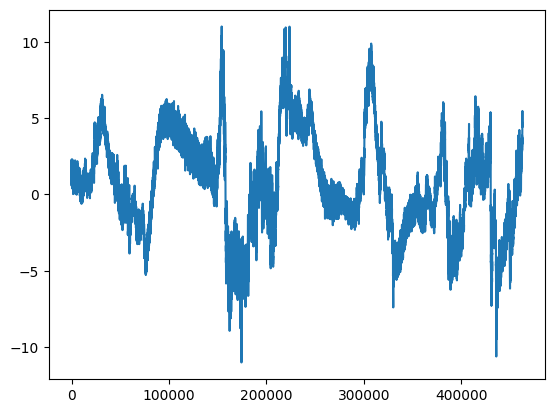

In [43]:
# Visualization of 1 patients signal and info
print(type(lead0[101]))
print(lead0[101].shape)
plt.plot(lead0[101])
print(info)

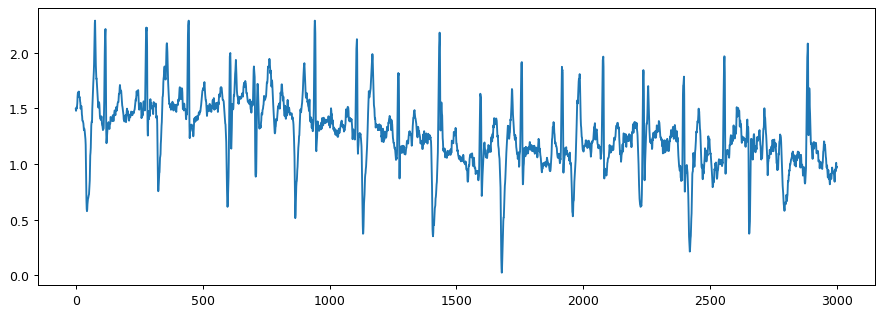

In [44]:
# ECG signal per second
a = lead0[101][0: 3000]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)

In [45]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(INCARTDB_DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 1]
        lead1[id_] = signals[:, 6]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [46]:
# Loading all patient ECG INFORMATION
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(INCARTDB_DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**16
    return info

In [47]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient I01 extracted
Signal of patient I02 extracted
Signal of patient I03 extracted
Signal of patient I04 extracted
Signal of patient I05 extracted
Signal of patient I06 extracted
Signal of patient I07 extracted
Signal of patient I08 extracted
Signal of patient I09 extracted
Signal of patient I10 extracted
Signal of patient I11 extracted
Signal of patient I12 extracted
Signal of patient I13 extracted
Signal of patient I14 extracted
Signal of patient I15 extracted
Signal of patient I16 extracted
Signal of patient I17 extracted
Signal of patient I18 extracted
Signal of patient I19 extracted
Signal of patient I20 extracted
Signal of patient I21 extracted
Signal of patient I22 extracted
Signal of patient I23 extracted
Signal of patient I24 extracted
Signal of patient I25 extracted
Signal of patient I26 extracted
Signal of patient I27 extracted
Signal of patient I28 extracted
Signal of patient I29 extracted
Signal of patient I30 extracted
Signal of patient I31 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

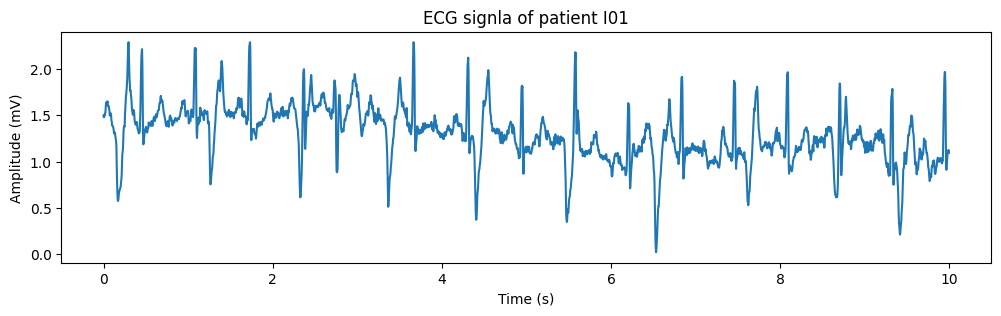

In [48]:
# Plot any patient signal from any time frame
patient_id = 'I01' # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*257
ending_signal_point = ending_time*257 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/257)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG signla of patient {patient_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

In [49]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 257,
 'sig_len': 462600,
 'n_sig': 12,
 'base_date': None,
 'base_time': None,
 'units': ['mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV',
  'mV'],
 'sig_name': ['I',
  'II',
  'III',
  'AVR',
  'AVL',
  'AVF',
  'V1',
  'V2',
  'V3',
  'V4',
  'V5',
  'V6'],
 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension',
  'patient 1',
  'PVCs, noise'],
 'resolution': 65536}

## Denoising

In [50]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

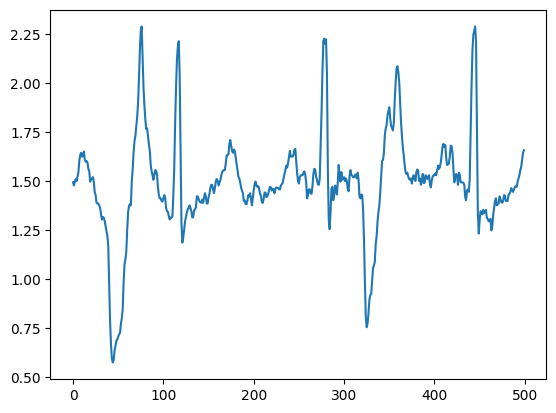

In [51]:
# Ploting a signal before denoising

record = wfdb.rdrecord(INCARTDB_DATA_ROOT + 'I01', channel_names=['II'])
data = record.p_signal.flatten()
plt.plot(data[0:500])

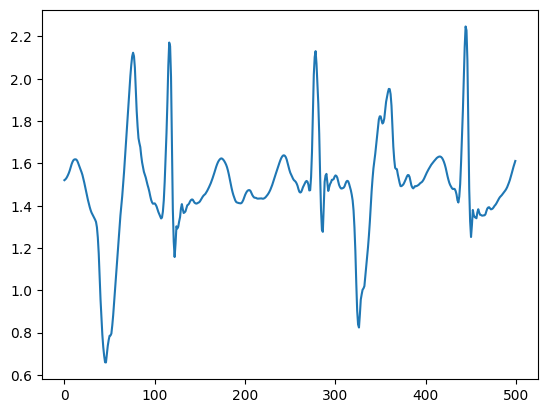

In [52]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

## R-Peak Detection

In [53]:
# For exmaple, we extract 'I01' recording annotation
annotation = wfdb.rdann(INCARTDB_DATA_ROOT + 'I01', 'atr')
Rlocation = annotation.sample
Rclass = annotation.symbol
print(Rlocation)
print(Rclass)

[   114    277    442 ... 462068 462243 462416]
['N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'V', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'V', 'N', 'V', 'N', 'N', 'N', 'V', 'N', 'N', 'N', 'N', 'N', 'N', '

In [54]:
len(annotation.symbol)

2757

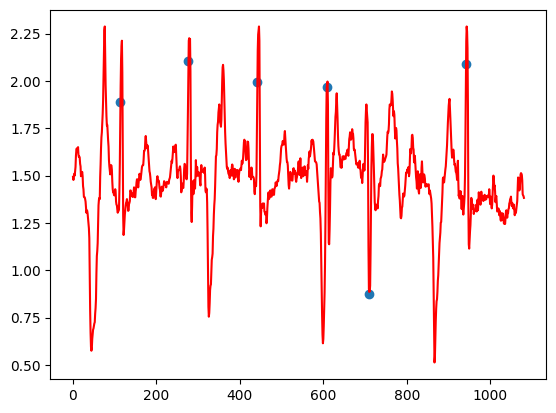

In [55]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak = 6
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

## Segmentation

(211,)
(211,)
(211,)


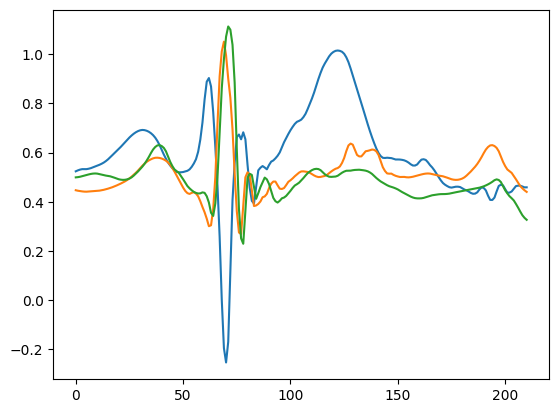

In [56]:
# Plotting 3 heartbeats
pre_samples = int(0.275 * 257)   # ~0.275 s before R-peak
post_samples = int(0.55 * 257)   # ~0.55 s after R-peak

k = np.arange(100, 103)
for i in k:
    start_idx = max(0, Rlocation[i] - pre_samples)
    end_idx = min(len(rdata), Rlocation[i] + post_samples)
    x_train = rdata[start_idx:end_idx]
    plt.plot(x_train)
    print(x_train.shape)
plt.show()

## Complete Preprocessing Figures

In [57]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

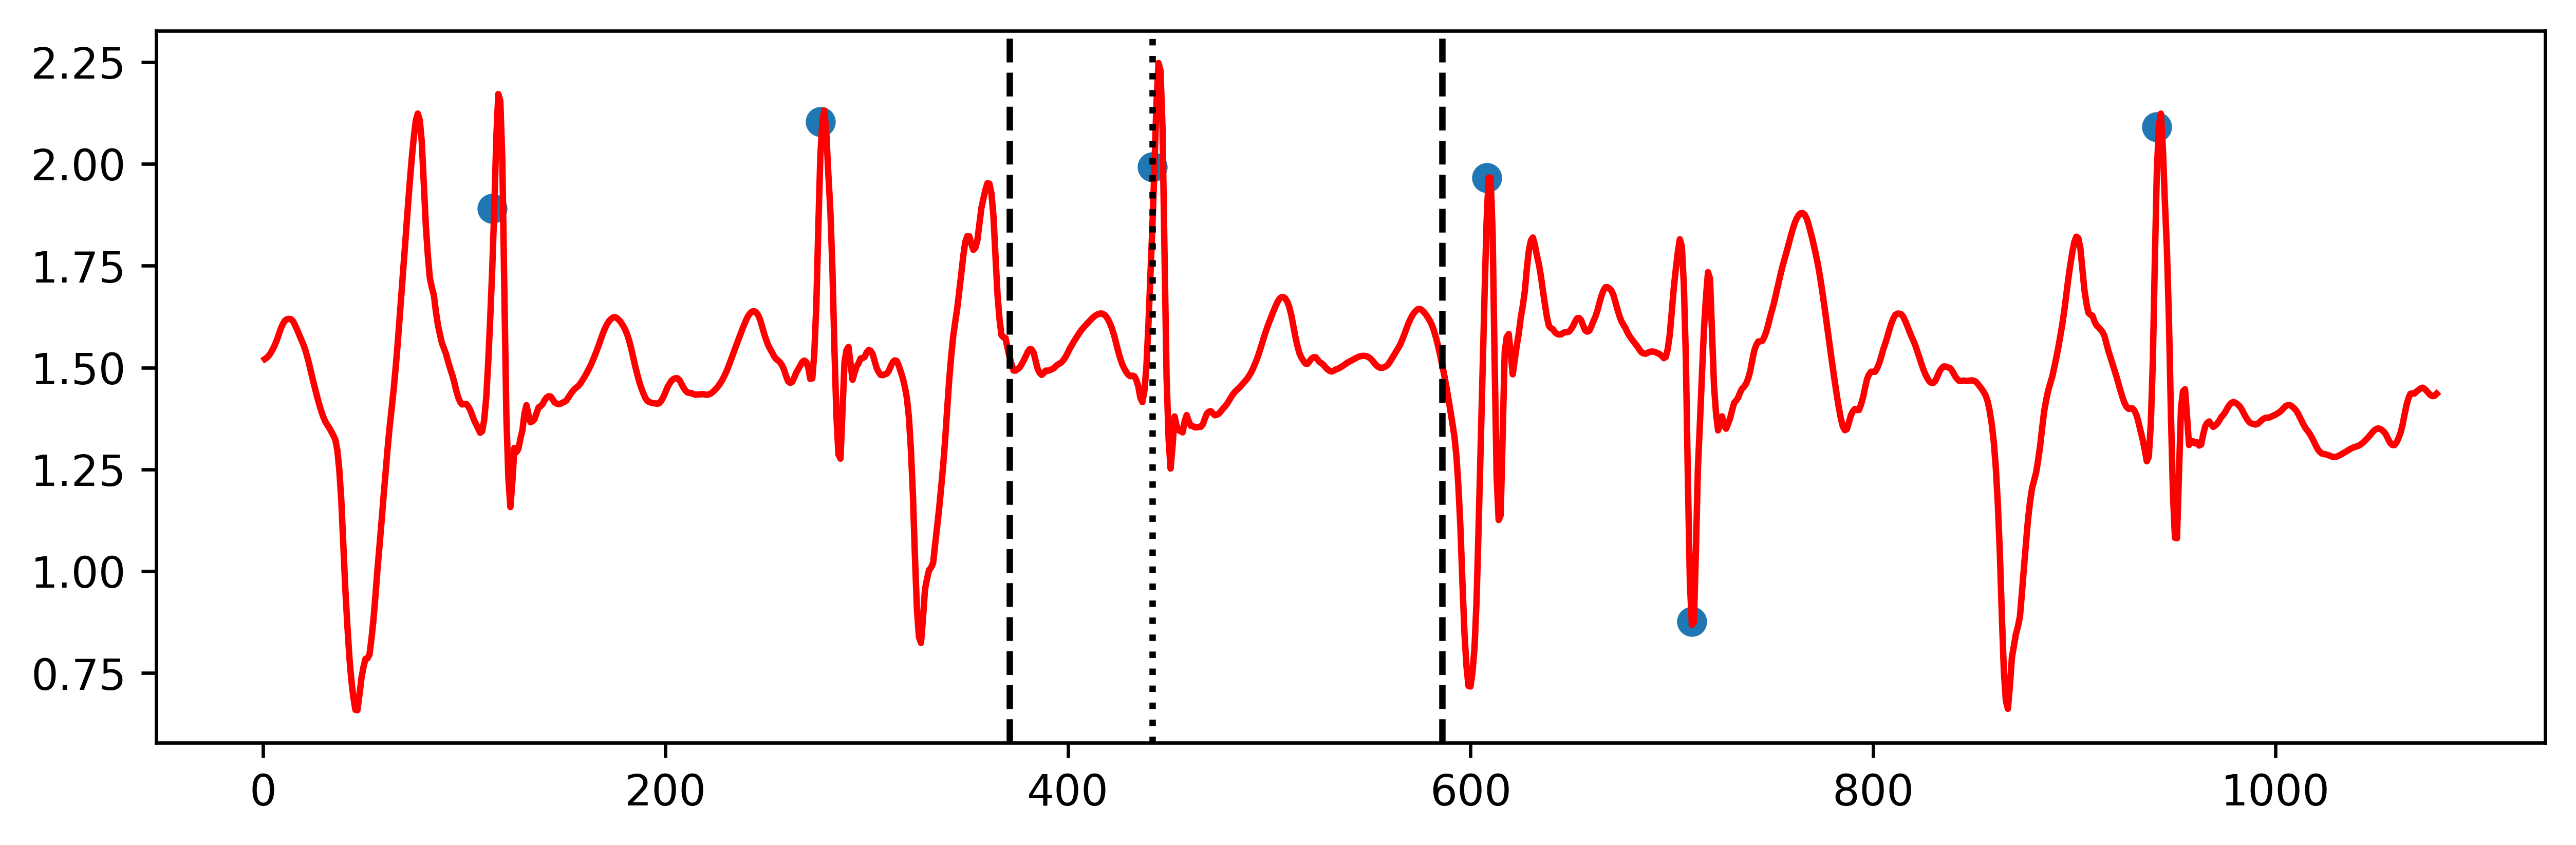

In [58]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak = 6
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':')
plt.axvline(x = Rlocation[2]-71, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+144, color = 'k', linestyle = '--')

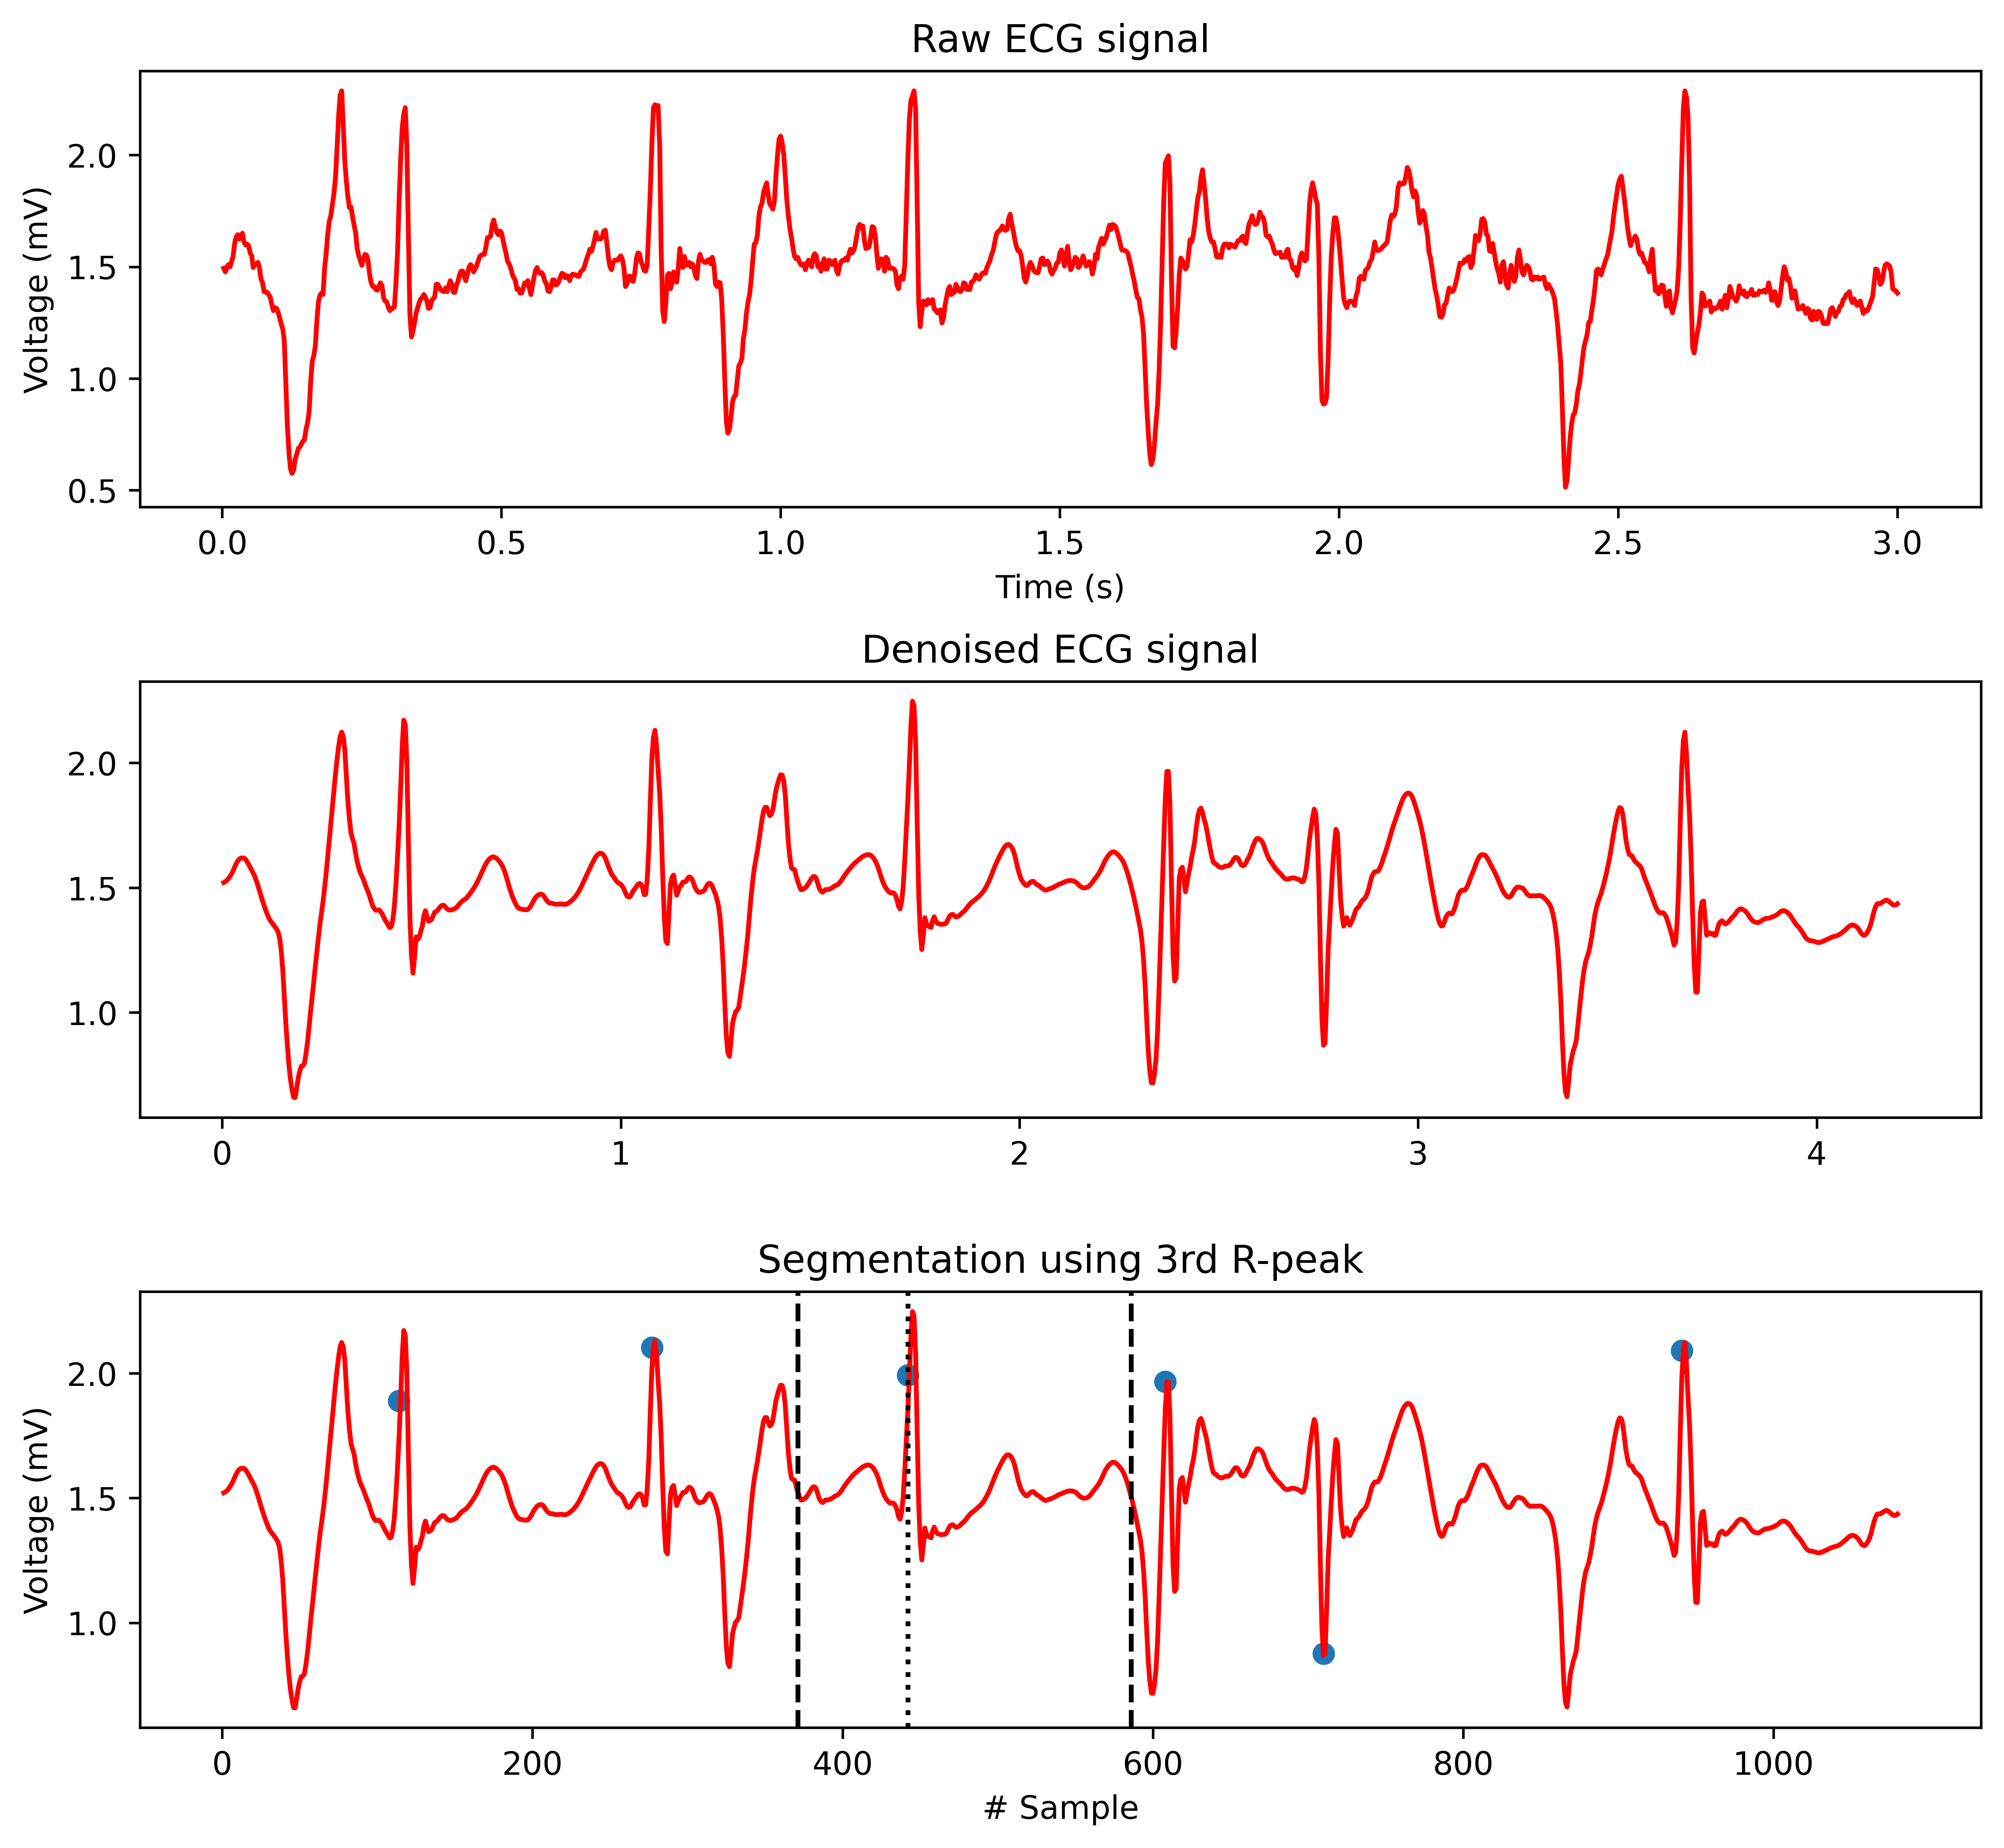

In [59]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/257, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak = 6
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-71, color = 'k', linestyle = '--')
plt.axvline(x = Rlocation[2]+144, color = 'k', linestyle = '--')

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

# 2. Dataset Loading

In [60]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(INCARTDB_DATA_ROOT, number))
    channels = info['sig_name']
    channel1, channel2 = channels[1], channels[6]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(INCARTDB_DATA_ROOT + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(INCARTDB_DATA_ROOT + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 71:Rlocation[i] + 144]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [61]:
# Load the dataset and preprocess it
def loadData():
    dataSet = []
    lableSet = []
    for n in patient_ids:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 215)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :215]
    Y = train_ds[:, 215]
    return X, Y

In [62]:
# Input X and Output Y data loading
X, Y = loadData()

II V1
reading I01 ECG data...
II V1
reading I02 ECG data...
II V1
reading I03 ECG data...
II V1
reading I04 ECG data...
II V1
reading I05 ECG data...
II V1
reading I06 ECG data...
II V1
reading I07 ECG data...
II V1
reading I08 ECG data...
II V1
reading I09 ECG data...
II V1
reading I10 ECG data...
II V1
reading I11 ECG data...
II V1
reading I12 ECG data...
II V1
reading I13 ECG data...
II V1
reading I14 ECG data...
II V1
reading I15 ECG data...
II V1
reading I16 ECG data...
II V1
reading I17 ECG data...
II V1
reading I18 ECG data...
II V1
reading I19 ECG data...
II V1
reading I20 ECG data...
II V1
reading I21 ECG data...
II V1
reading I22 ECG data...
II V1
reading I23 ECG data...
II V1
reading I24 ECG data...
II V1
reading I25 ECG data...
II V1
reading I26 ECG data...
II V1
reading I27 ECG data...
II V1
reading I28 ECG data...
II V1
reading I29 ECG data...
II V1
reading I30 ECG data...
II V1
reading I31 ECG data...
II V1
reading I32 ECG data...
II V1
reading I33 ECG data...
II V1
read

In [63]:
# Counting the number of each type of heartbeats
from collections import Counter

Y_list = list(Y)
Counter(Y_list)

Counter({np.float64(0.0): 150087,
         np.float64(9.0): 19980,
         np.float64(11.0): 219,
         np.float64(2.0): 3164,
         np.float64(5.0): 1941,
         np.float64(4.0): 92,
         np.float64(14.0): 6,
         np.float64(8.0): 16})

# 3. Train-Test Splitting and Class Balancing

In [64]:
# Load the dataset and preprocess it
def loadData():
    dataSet = []
    lableSet = []
    for n in patient_ids:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 215)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [65]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300
# and 301 colum is its label among 15 difference level
train_ds = loadData()

II V1
reading I01 ECG data...
II V1
reading I02 ECG data...
II V1
reading I03 ECG data...
II V1
reading I04 ECG data...
II V1
reading I05 ECG data...
II V1
reading I06 ECG data...
II V1
reading I07 ECG data...
II V1
reading I08 ECG data...
II V1
reading I09 ECG data...
II V1
reading I10 ECG data...
II V1
reading I11 ECG data...
II V1
reading I12 ECG data...
II V1
reading I13 ECG data...
II V1
reading I14 ECG data...
II V1
reading I15 ECG data...
II V1
reading I16 ECG data...
II V1
reading I17 ECG data...
II V1
reading I18 ECG data...
II V1
reading I19 ECG data...
II V1
reading I20 ECG data...
II V1
reading I21 ECG data...
II V1
reading I22 ECG data...
II V1
reading I23 ECG data...
II V1
reading I24 ECG data...
II V1
reading I25 ECG data...
II V1
reading I26 ECG data...
II V1
reading I27 ECG data...
II V1
reading I28 ECG data...
II V1
reading I29 ECG data...
II V1
reading I30 ECG data...
II V1
reading I31 ECG data...
II V1
reading I32 ECG data...
II V1
reading I33 ECG data...
II V1
read

In [66]:
Y = train_ds[:, 215]

In [67]:
# Here 15 class of ECG data are saved
Y_list = list(Y)
Counter(Y_list)

Counter({np.float64(0.0): 150087,
         np.float64(9.0): 19980,
         np.float64(2.0): 3164,
         np.float64(5.0): 1941,
         np.float64(11.0): 219,
         np.float64(4.0): 92,
         np.float64(8.0): 16,
         np.float64(14.0): 6})

In [68]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [69]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({np.float64(0.0): 153343,
         np.float64(2.0): 19980,
         np.float64(1.0): 1957,
         np.float64(3.0): 219,
         np.float64(4.0): 6})

In [70]:
ecg_dataset = np.copy(train_ds)

In [71]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [72]:
ecg_data = ecg_dataset[:, :215]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work

In [73]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

In [75]:
# Keep only N, S, V classes (labels 0, 1, 2)
ecg_data = ecg_dataset_5[:, :215]
ecg_label = ecg_dataset_5[:, 215]
selected_indices = np.where((ecg_label == 0) | (ecg_label == 1) | (ecg_label == 2))[0]

ecg_data = ecg_data[selected_indices]
ecg_label = ecg_label[selected_indices]

ecg_dataset_5 = np.hstack((ecg_data, ecg_label.reshape(-1, 1)))

## Per-Class Data Status Checking

In [77]:
# Convert ndarray to dataframe
df_ecg = pd.DataFrame(ecg_dataset_5)
class_data = df_ecg[215].value_counts()
class_data

,count
215,
0.0,153343
2.0,19980
1.0,1957


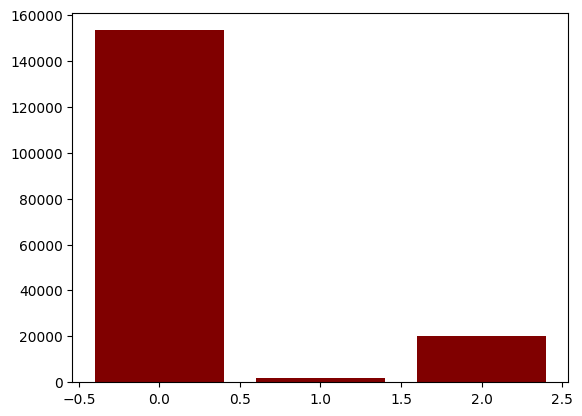

In [78]:
# per class data status plotting,
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

<Axes: xlabel='215'>

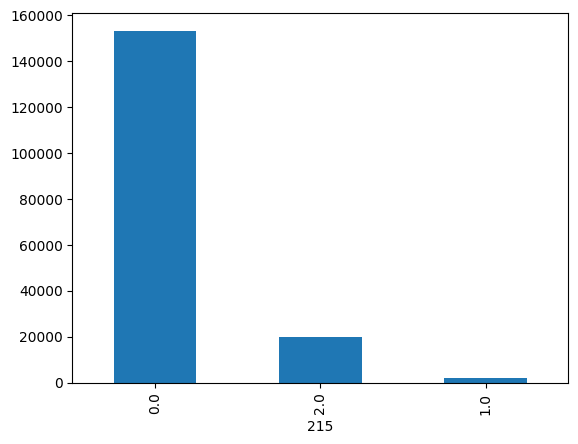

In [80]:
# shortcut for per class data status plotting,
# Order is not maintained by class. Higher to lower
df_ecg[215].value_counts().plot(kind='bar')

## Train-Test Splitting

In [81]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :215]
ecg_label = ecg_dataset_5[:, 215]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

In [82]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [83]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [84]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'incart_test_data.pkl'
test_data.to_pickle(file_name)

### Training dataset status checking: balanced / imbalanced

215
0.0    122731
2.0     15933
1.0      1560
Name: count, dtype: int64


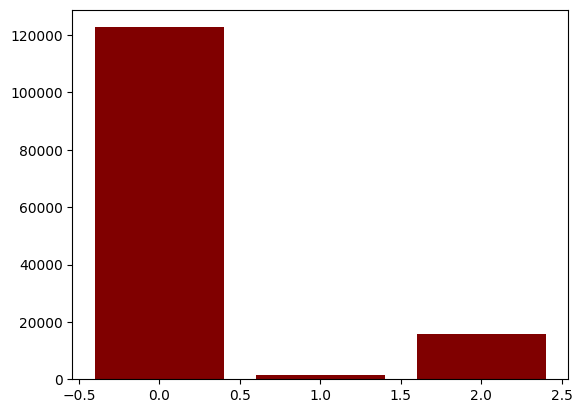

In [85]:
# Imblanced training data graph ploting
class_data = train_data[215].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

## Class Balancing by Undersampling and SMOTE

In [86]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[215] == 0)]
train_data_1234 = train_data.loc[(train_data[215] != 0)]

In [87]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [88]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

In [89]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-2.79516832, -2.78267651, -2.77269528, ..., -3.00794558,
        -3.00796508,  1.        ],
       [11.49545305, 11.50197221, 11.50835209, ..., 12.70332162,
        12.72610978,  0.        ],
       [ 7.63157497,  7.63513234,  7.64119501, ...,  9.13627117,
         9.15576476,  2.        ],
       ...,
       [-3.11153236, -3.13660127, -3.16024228, ..., -3.42159998,
        -3.62974148,  0.        ],
       [-1.87164577, -1.8715747 , -1.87076086, ..., -0.39795259,
        -0.71345423,  0.        ],
       [ 3.24111695,  3.23888597,  3.23707863, ...,  3.1675613 ,
         3.16709641,  0.        ]])

215
1.0    50000
0.0    50000
2.0    50000
Name: count, dtype: int64


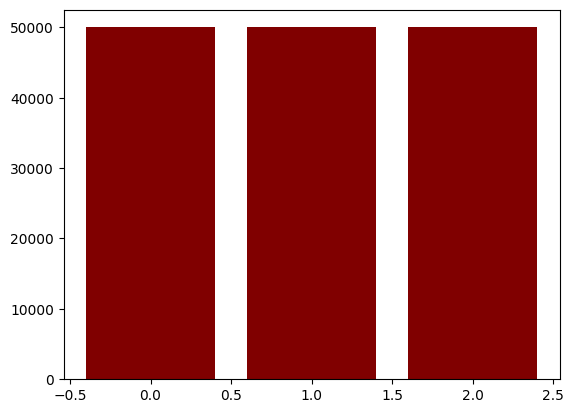

In [90]:
# blanced training data graph ploting
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[215].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = project_path + 'incart_train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [91]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 3)

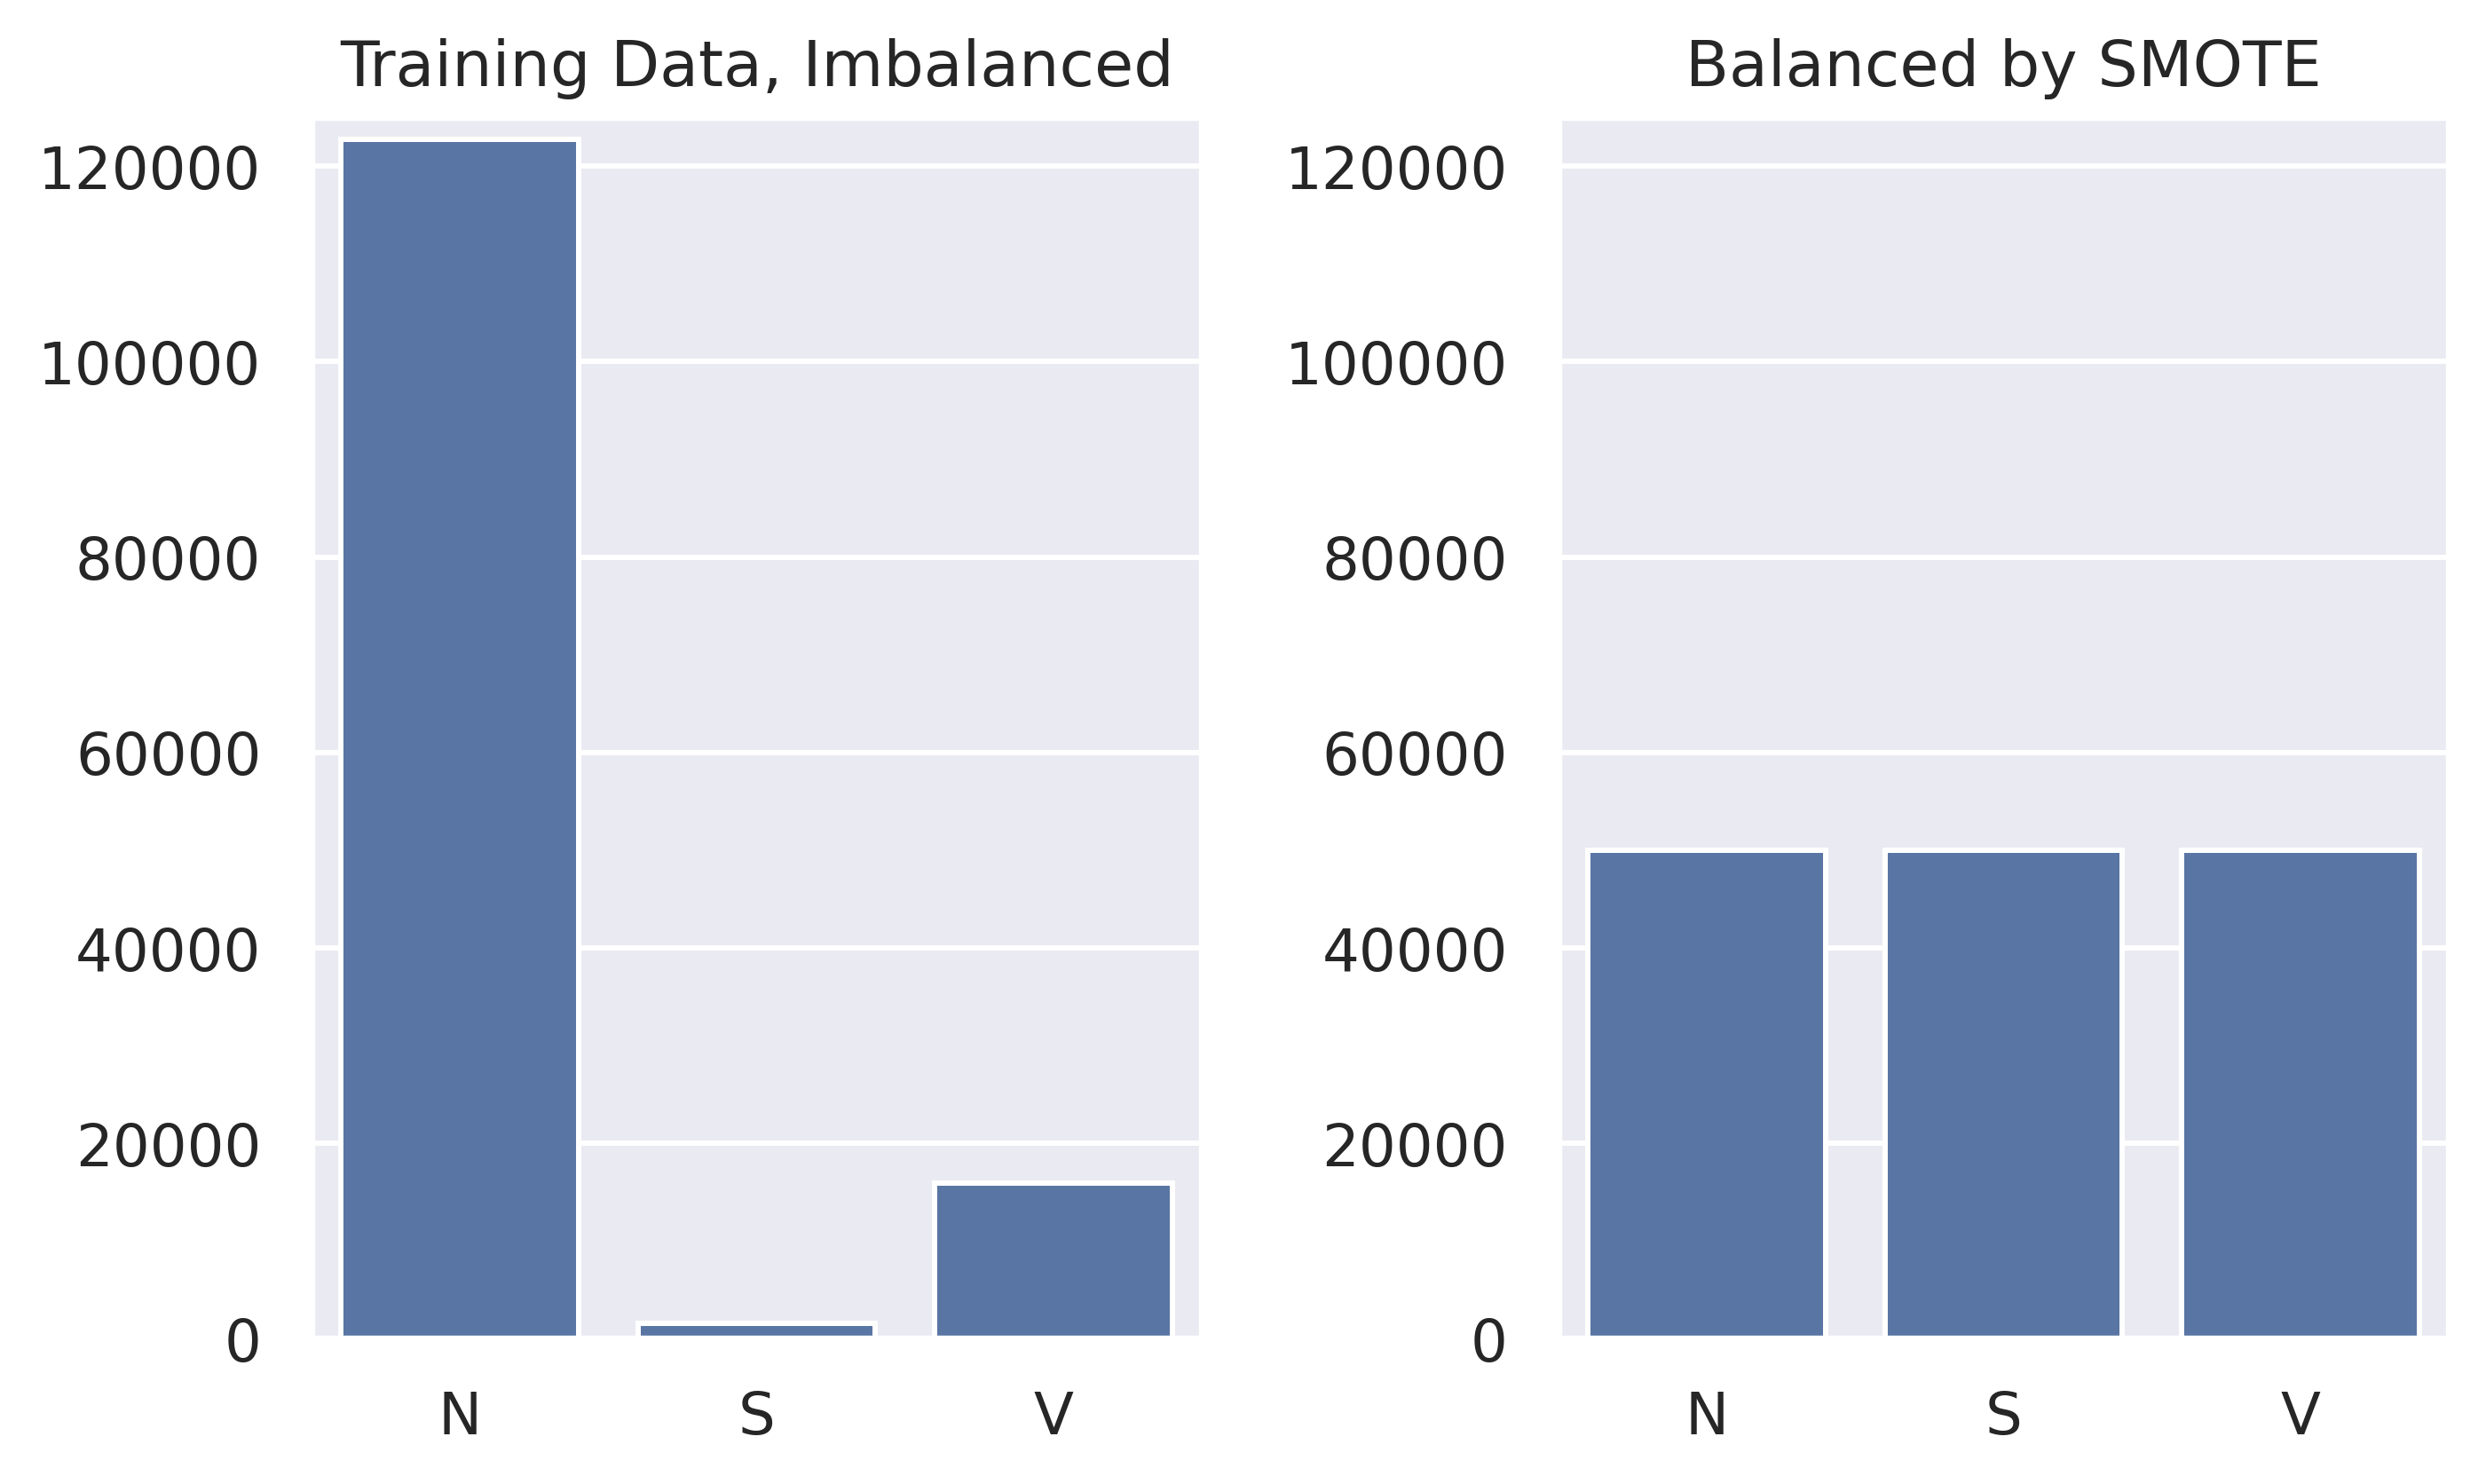

In [92]:
# a single plot which gives proper illustration before and after class balancing
import seaborn as sns
sns.set()
sns.color_palette("hls", 8)

fig = plt.figure(figsize=(7,4), dpi=430)
plt.subplot(121)
sns.barplot(x = ['N', 'S', 'V'], y = [122731, 1560, 15933])
plt.ylim(0, 125000)
plt.title('Training Data, Imbalanced')

plt.subplot(122)
sns.barplot(x = ['N', 'S', 'V'], y = class_data.values)
plt.ylim(0, 125000)
plt.title('Balanced by SMOTE')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

fig.savefig(figure_path + 'Incart_Class balancing.png')

# 4. Model Building and Training

## Attetion Mechanism

In [93]:
# udf for channel attention mechanism
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = self.shared_layer_one(max_pool)
            max_pool = self.shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [94]:
# udf for spatial attention mechanism
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

## CNN-LSTM and Attention Model Architecture

In [95]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(215, 1)),
        # The first convolutional layer, sixteen 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        ChannelAttention(16, 8),
        # SpatialAttention(7),
        # The first pooling layer, max pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The second convolution layer, 32 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        ChannelAttention(32, 8),
        # SpatialAttention(7),
        # The second pooling layer, max pooling, 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The third convolution layer, 64 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        ChannelAttention(64, 8),
        # SpatialAttention(7),
        # The third pooling layer, average pooling, 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 128 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        ChannelAttention(128, 8),
        SpatialAttention(7),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 32 nodes
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return newModel

In [96]:
# Build a CNN model
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(215, 1)),
        # The first convolutional layer, four 21x1 convolution kernels
        tf.keras.layers.Conv1D(filters=16, kernel_size=21, strides=1, padding='same', activation='relu'),
        # The first pooling layer, max pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The second convolution layer, 16 23x1 convolution kernels
        tf.keras.layers.Conv1D(filters=32, kernel_size=23, strides=1, padding='same', activation='relu'),
        # The second pooling layer, max pooling, four 3x1 convolution kernels, with a stride of 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same'),
        # The third convolution layer, 32 25x1 convolution kernels
        tf.keras.layers.Conv1D(filters=64, kernel_size=25, strides=1, padding='same', activation='relu'),
        # The third pooling layer, average pooling, four 3x1 convolution kernels, stride 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='same'),
        # The fourth convolution layer, 64 27x1 convolution kernels
        tf.keras.layers.Conv1D(filters=128, kernel_size=27, strides=1, padding='same', activation='relu'),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(128, return_sequences=True),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # LSTM layer, 64 nodes
        tf.keras.layers.LSTM(64, return_sequences=True),
        # Flatten the layer to facilitate the processing of the fully connected layer
        tf.keras.layers.Flatten(),
        # Fully connected layer, 128 nodes
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout layer,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # Fully connected layer, 5 nodes
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return newModel

## Model Training

In [99]:
#Define the log directory, which must be a subdirectory of the specified
#directory when starting the web application. It is recommended to use date and time as the subdirectory name
logdir = project_path + "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_path = project_path + "incart_ecg_model_code 17_t5.h5"

In [100]:
# percentage of training data used for model validation
ratio = 0.2

In [101]:
if os.path.exists(model_path):
  # Import the trained model
  print('Model is already in the filepath')
  model = tf.keras.models.load_model(filepath=model_path)
else:
  # Build a CNN model
  print('Model not found, now building and then saving')
  model = buildModel()
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # Define the TensorBoard object
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
  checkpoint_filepath = project_path + "incart_code_17_t5.weights.h5"

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True
  )

  callback_list = [tensorboard_callback, model_checkpoint_callback]
  # Training and Validation
  history = model.fit(x_train, y_train, epochs=30,
            batch_size=128,
            validation_split=ratio,
            callbacks=callback_list)
  model.save(filepath=model_path)

Model not found, now building and then saving


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 215, 16)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 108, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 108, 32)        │        11,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 54, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 54, 64)         │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 27, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 128)        │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 27, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 27, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,427 (2.62 MB)

 Trainable params: 687,427 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9299 - loss: 0.2415 - val_accuracy: 0.9828 - val_loss: 0.0603
Epoch 2/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9842 - loss: 0.0591 - val_accuracy: 0.9892 - val_loss: 0.0417
Epoch 3/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9887 - loss: 0.0437 - val_accuracy: 0.9897 - val_loss: 0.0397
Epoch 4/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9912 - loss: 0.0341 - val_accuracy: 0.9923 - val_loss: 0.0311
Epoch 5/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9926 - loss: 0.0295 - val_accuracy: 0.9898 - val_loss: 0.0350
Epoch 6/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9925 - loss: 0.0284 - val_accuracy: 0.9886 - val_loss: 0.0392
Epoch 7/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9930 - loss: 0.0257 - val_accuracy: 0.9949 - val_loss: 0.0205
Epoch 8/30
877/877 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9944 - loss: 0.0207 - 

# 5. Plotting Accuracy and Loss

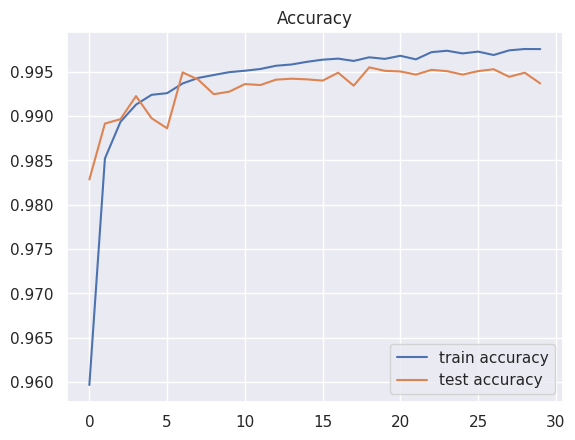

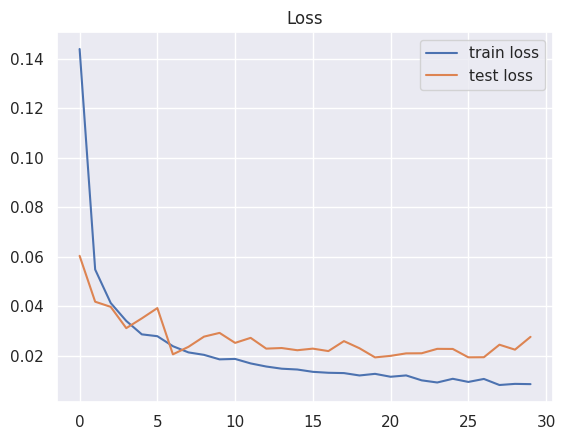

In [102]:
# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss') # label is actually 'validation accuracy'
plt.legend()
plt.show()

# 6. Results

In [103]:
# evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 99.59, Test Accuracy: 99.44
Training Loss: 1.58, Test Loss: 3.00


In [104]:
# model2 taken fro model_checkpoint callback
model2 = buildModel()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Update the weights with best validation accuracy # Loads the weights
model2.load_weights(checkpoint_filepath)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [105]:
# evaluate the best model
train_loss_cp, train_acc_cp = model2.evaluate(x_train, y_train, verbose=0)
test_loss_cp, test_acc_cp = model2.evaluate(x_test, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc_cp*100, test_acc_cp*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss_cp*100, test_loss_cp*100))

Training Accuracy: 99.69, Test Accuracy: 99.51
Training Loss: 1.35, Test Loss: 2.42


## Confusion Matrix

In [106]:
# confusion matrix
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # Normalized
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # Plotting
    plt.figure(figsize=(12, 8))
    seaborn.heatmap(con_mat, annot=True, square=True, fmt='.20g', cmap='Greens')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


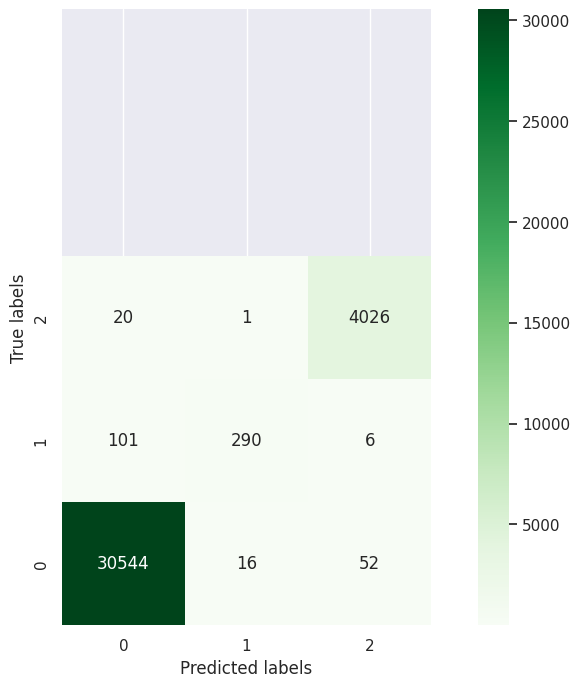

In [107]:
# predict
Y_pred = np.argmax(model.predict(x_test), axis=-1)
# Y_pred = model.predict_classes(X_test)
# plot confusion matrix
plotHeatMap(y_test, Y_pred)

## Per-Class Accuracy

In [108]:
# Per class accuracy printing function
def _report(TN, FP, FN, TP):
    TPR = TP/(TP+FN) if (TP+FN)!=0 else 0
    TNR = TN/(TN+FP) if (TN+FP)!=0 else 0
    PPV = TP/(TP+FP) if (TP+FP)!=0 else 0
    '''
    report = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
              'TPR': TPR, 'Recall': TPR, 'Sensitivity': TPR,
              'TNR' : TNR, 'Specificity': TNR,
              'FPR': FP/(FP+TN) if (FP+TN)!=0 else 0,
              'FNR': FN/(FN+TP) if (FN+TP)!=0 else 0,
              'PPV': PPV, 'Precision': PPV,
              'F1 Score': 2*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy': (TP+TN)/(TP+FP+FN+TN)
             }'''

    report = {'Sensitivity (%)': TPR*100,
              'Specificity (%)': TNR*100,
              'F1 Score (%)': 2*100*(PPV*TPR)/(PPV+TPR),
              'Per Class Accuracy (%)': (TP+TN)*100/(TP+FP+FN+TN)
             }
    return report

def multi_classification_report(y_test, y_pred, labels=None, encoded_labels=True, as_frame=False):
    """
    Args:
        y_test (ndarray)
        y_pred (ndarray)
        labels (list)
        encoded_labels (bool): Need to be False if labels are not one hot encoded
        as_fram (bool): If True, return type will be DataFrame

    Return:
        report (dict)
    """

    import numpy as np
    import pandas as pd
    from sklearn.metrics import multilabel_confusion_matrix

    conf_labels = None if encoded_labels else labels

    conf_mat = multilabel_confusion_matrix(y_test, y_pred, labels=conf_labels)
    report = dict()
    if labels == None:
        counter = np.arange(len(conf_mat))
    else:
        counter = labels

    for i, name in enumerate(counter):
        TN, FP, FN, TP = conf_mat[i].ravel()
        report[name] = _report(TN, FP, FN, TP)

    if as_frame:
        return pd.DataFrame(report)
    return report

In [109]:
# Per class performance
labels = ['N', 'S', 'V']
Y_pred = np.argmax(model.predict(x_test), axis=-1)
multi_classification_report(y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


,N,S,V
Sensitivity (%),99.777865,73.047859,99.481097
Specificity (%),97.277228,99.950951,99.812958
F1 Score (%),99.691565,82.386364,99.028410
Per Class Accuracy (%),99.460863,99.646280,99.774646


In [110]:
# Per class performance
labels = ['N', 'S', 'V']
Y_pred = np.argmax(model2.predict(x_test), axis=-1)
multi_classification_report(y_test, Y_pred, labels=labels, encoded_labels=True, as_frame=True)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


,N,S,V
Sensitivity (%),99.885666,77.833753,98.789227
Specificity (%),97.074707,99.948065,99.922603
F1 Score (%),99.730915,85.359116,99.095303
Per Class Accuracy (%),99.529325,99.697627,99.791762
